# Radial basis functions on a pendulum

This example shows how thin-plate radial basis functions can be used as lifting functions to identify pendulum dynamics (where all trajectories have zero initial velocity). These RBFs have the form ${\bf \psi}_i({\bf x}) = \|{\bf x} - {\bf c}_i\|^2 \ln(\|{\bf x} - {\bf c}_i\|)$. Latin hypercube sampling is used to generate 100 centers ${\bf c}_i$ from the training data.

In [1]:
# Imports
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

import pykoop

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_pendulum()

Create and fit a Koopman pipeline with radial basis function (RBF) lifting functions. Centers are generated using Latin hypercube sampling.

In [3]:
# Create pipeline
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rbf',
        pykoop.RbfLiftingFn(
            rbf='thin_plate',
            centers=pykoop.QmcCenters(
                n_centers=100,
                qmc=scipy.stats.qmc.LatinHypercube,
                random_state=666,
            ),
        ),
    )],
    regressor=pykoop.Edmd(),
)

# Fit the pipeline
kp.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)

KoopmanPipeline(lifting_functions=[('rbf',
                                    RbfLiftingFn(centers=QmcCenters(qmc=<class 'scipy.stats._qmc.LatinHypercube'>,
                                                                    random_state=666),
                                                 rbf='thin_plate'))],
                regressor=Edmd())

Extract the training and validaiton episodes numbers from the example data.

In [4]:
ep_train = np.unique(eg['X_train'][:, 0])
ep_valid = np.unique(eg['X_valid'][:, 0])

Plot the training episodes and the chosen centers. In phase space (angle vs. velocity), the pendulum has an orbit for each angle wraparound of $2 \pi$ radians.

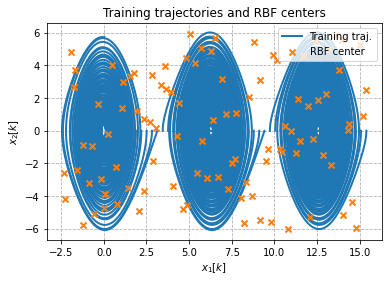

In [5]:
# Plot training trajectories
fig, ax = plt.subplots()
for ep in ep_train:
    idx = eg['X_train'][:, 0] == ep
    cax_line = ax.plot(
        eg['X_train'][idx, 1],
        eg['X_train'][idx, 2],
        color='C0',
    )
# Plot centers
c = kp.lifting_functions_[0][1].centers_.centers_
for i in range(c.shape[0]):
    cax_scatter = ax.scatter(
        c[i, 0],
        c[i, 1],
        color='C1',
        marker='x',
        zorder=2,
    )
# Set legend
ax.legend(
    [cax_line[0], cax_scatter],
    [
        'Training traj.',
        'RBF center',
    ],
    loc='upper right',
)
# Set labels
ax.set_title('Training trajectories and RBF centers')
ax.set_xlabel('$x_1[k]$')
ax.set_ylabel('$x_2[k]$')
# Save axis limits for next figure
xlim = ax.get_xlim()
ylim = ax.get_ylim()

Predict three new trajectories from initial conditions in the validation set.

In [6]:
# Predict new trajectories
X_pred = kp.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
)

Plot the predictions and their ground truth trajectories. Since the initial velocities are zero, each trajectory settles into its nearest orbit, as expected. At high velocities, trajectories can jump orbits.

Text(0, 0.5, '$x_2[k]$')

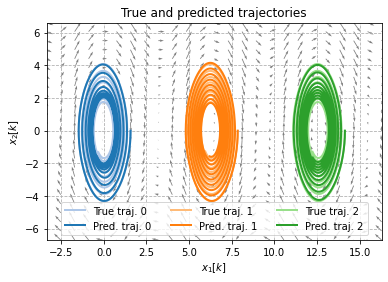

In [7]:
# Plot validation trajectories
fig, ax = plt.subplots()
tab20 = plt.cm.tab20(np.arange(0, 1, 0.05))
color = [
    (tab20[1], tab20[0]),
    (tab20[3], tab20[2]),
    (tab20[5], tab20[4]),
]
for (i, ep) in enumerate(ep_valid):
    idx = eg['X_valid'][:, 0] == ep
    cax_valid = ax.plot(
        eg['X_valid'][idx, 1],
        eg['X_valid'][idx, 2],
        color=color[i][0],
        label=f'True traj. {i}',
    )
    cax_pred = ax.plot(
        X_pred[idx, 1],
        X_pred[idx, 2],
        label=f'Pred. traj. {i}',
    )
# Set axis limits
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
# Plot true vector field
pend = eg['dynamic_model']
xx, yy = np.meshgrid(np.linspace(*xlim, 25), np.linspace(*ylim, 25))
x = np.vstack((xx.ravel(), yy.ravel()))
x_dot = np.array([pend.f(0, x[:, k], 0) for k in range(x.shape[1])]).T
ax.quiver(x[0, :], x[1, :], x_dot[0, :], x_dot[1, :], color='grey')
# Set legend
ax.legend(loc='lower center', ncol=3)
# Set labels
ax.set_title('True and predicted trajectories')
ax.set_xlabel('$x_1[k]$')
ax.set_ylabel('$x_2[k]$')